In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForTokenClassification
from transformers import DistilBertForTokenClassification
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np



tokenizer = BertTokenizer.from_pretrained("cl-tohoku/bert-base-japanese")
model = BertModel.from_pretrained("cl-tohoku/bert-base-japanese")


print(model.config)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "cl-tohoku/bert-base-japanese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



In [2]:



with open("output-train.json", "r", encoding="utf-8") as file:
    data_train = json.load(file)


print(f"nums: {len(data_train)}")
print(f"firstdata: {data_train[0]}")

with open("output-val.json", "r", encoding="utf-8") as file:
    data_val = json.load(file)


print(f"nums: {len(data_val)}")
print(f"firstdata: {data_val[0]}")


with open("output-test.json", "r", encoding="utf-8") as file:
    data_test = json.load(file)

print(f"nums: {len(data_test)}")
print(f"firstdata: {data_test[0]}")


nums: 7481
firstdata: {'sentence': 'ホッケーにはデンジャラスプレーの反則があるので、膝より上にボールを浮かすことは基本的に反則になるが、その例外の一つがこのスクープである。', 'tokens': [{'word': 'ホッケー', 'pos': '名詞'}, {'word': 'に', 'pos': '助詞'}, {'word': 'は', 'pos': '助詞'}, {'word': 'デンジャラス', 'pos': '名詞'}, {'word': 'プレー', 'pos': '名詞'}, {'word': 'の', 'pos': '助詞'}, {'word': '反則', 'pos': '名詞'}, {'word': 'が', 'pos': '助詞'}, {'word': 'ある', 'pos': '動詞'}, {'word': 'の', 'pos': '助詞'}, {'word': 'で', 'pos': '助動詞'}, {'word': '、', 'pos': '補助記号'}, {'word': '膝', 'pos': '名詞'}, {'word': 'より', 'pos': '助詞'}, {'word': '上', 'pos': '名詞'}, {'word': 'に', 'pos': '助詞'}, {'word': 'ボール', 'pos': '名詞'}, {'word': 'を', 'pos': '助詞'}, {'word': '浮かす', 'pos': '動詞'}, {'word': 'こと', 'pos': '名詞'}, {'word': 'は', 'pos': '助詞'}, {'word': '基本', 'pos': '名詞'}, {'word': '的', 'pos': '接尾辞'}, {'word': 'に', 'pos': '助動詞'}, {'word': '反則', 'pos': '名詞'}, {'word': 'に', 'pos': '助詞'}, {'word': 'なる', 'pos': '動詞'}, {'word': 'が', 'pos': '助詞'}, {'word': '、', 'pos': '補助記号'}, {'word': 'その', 'pos': '連体詞'}, {'word': '例外

In [3]:

def preprocess_data(data):
    sentences = []
    token_labels = []

    for item in data:
        sentence = item["sentence"]  
        tokens = [token["word"] for token in item["tokens"]]  
        pos_tags = [token["pos"] for token in item["tokens"]] 

        sentences.append(sentence)
        token_labels.append((tokens, pos_tags))

    return sentences, token_labels


sentences_train, token_labels_train = preprocess_data(data_train)
sentences_val, token_labels_val = preprocess_data(data_val)
sentences_test, token_labels_test = preprocess_data(data_test)


print(f"sentence: {sentences_train[0]}")
print(f"pos: {token_labels_train[0]}")


sentence: ホッケーにはデンジャラスプレーの反則があるので、膝より上にボールを浮かすことは基本的に反則になるが、その例外の一つがこのスクープである。
pos: (['ホッケー', 'に', 'は', 'デンジャラス', 'プレー', 'の', '反則', 'が', 'ある', 'の', 'で', '、', '膝', 'より', '上', 'に', 'ボール', 'を', '浮かす', 'こと', 'は', '基本', '的', 'に', '反則', 'に', 'なる', 'が', '、', 'その', '例外', 'の', '一', 'つ', 'が', 'この', 'スクープ', 'で', 'ある', '。'], ['名詞', '助詞', '助詞', '名詞', '名詞', '助詞', '名詞', '助詞', '動詞', '助詞', '助動詞', '補助記号', '名詞', '助詞', '名詞', '助詞', '名詞', '助詞', '動詞', '名詞', '助詞', '名詞', '接尾辞', '助動詞', '名詞', '助詞', '動詞', '助詞', '補助記号', '連体詞', '名詞', '助詞', '名詞', '接尾辞', '助詞', '連体詞', '名詞', '助動詞', '動詞', '補助記号'])


In [4]:
def generate_label_to_id(data):
    label_set = set()
    for item in data:
        for token in item["tokens"]:
            label_set.add(token["pos"]) 

    # 创建映射
    label_to_id = {label: idx for idx, label in enumerate(sorted(label_set), start=1)}
    return label_to_id


all_data = data_train + data_val + data_test
label_to_id = generate_label_to_id(all_data)


print("Label to ID mapping:", label_to_id)


Label to ID mapping: {'代名詞': 1, '副詞': 2, '助動詞': 3, '助詞': 4, '動詞': 5, '名詞': 6, '形容詞': 7, '形状詞': 8, '感動詞': 9, '接尾辞': 10, '接続詞': 11, '接頭辞': 12, '補助記号': 13, '記号': 14, '連体詞': 15}


In [5]:

# Function to preprocess data and convert to BERT format
def encode_data(data, tokenizer, label_to_id, max_len=128):
    input_ids = []
    attention_masks = []
    labels = []

    for item in data:
        # Extract sentences and labels
        sentence = item["sentence"]
        tokens = [token["word"] for token in item["tokens"]]
        pos_tags = [token["pos"] for token in item["tokens"]]

        # Tokenize the input sentence
        encoding = tokenizer(
            sentence,
            truncation=True,
            max_length=max_len,
            padding='max_length',
            return_tensors='pt',
            is_split_into_words=False  # Tokenize as a whole sentence
        )

        # Convert labels to IDs
        label_ids = [0] * max_len  # Default label for special tokens like [CLS] and [SEP]
        for idx, pos in enumerate(pos_tags[:max_len - 2]):  # Exclude special tokens
            label_ids[idx + 1] = label_to_id.get(pos, 0)  # Offset by 1 to skip [CLS]

        input_ids.append(encoding['input_ids'].squeeze(0))
        attention_masks.append(encoding['attention_mask'].squeeze(0))
        labels.append(torch.tensor(label_ids))

    # Convert lists to tensors
    return torch.stack(input_ids), torch.stack(attention_masks), torch.stack(labels)

# Convert training, validation, and test datasets
input_ids_train, attention_masks_train, labels_train = encode_data(data_train, tokenizer, label_to_id)
input_ids_val, attention_masks_val, labels_val = encode_data(data_val, tokenizer, label_to_id)
input_ids_test, attention_masks_test, labels_test = encode_data(data_test, tokenizer, label_to_id)

# Print the shapes of the converted data
print(f"input_ids_train shape: {input_ids_train.shape}")
print(f"attention_masks_train shape: {attention_masks_train.shape}")
print(f"labels_train shape: {labels_train.shape}")


input_ids_train shape: torch.Size([7481, 128])
attention_masks_train shape: torch.Size([7481, 128])
labels_train shape: torch.Size([7481, 128])


In [6]:


# Create a TensorDataset from the data
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Print the number of batches
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Number of training batches: 468
Number of validation batches: 34


In [7]:

# Initialize the model
# Correctly set num_labels
model = BertForTokenClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese",
    num_labels=len(label_to_id) + 1  # Adjust num_labels
)
for param in model.bert.embeddings.parameters():
    param.requires_grad = False  # Freeze embeddings
for param in model.bert.encoder.layer[:5].parameters():
    param.requires_grad = False  # Freeze first 6 encoder layers

# Check frozen parameters
frozen_params = sum(1 for param in model.parameters() if not param.requires_grad)
print(f"Number of frozen parameters: {frozen_params}")
# Print the model architecture
print(model)
model.config.hidden_dropout_prob = 0.3  # Hidden layer dropout
#model.config.attention_probs_dropout_prob = 0.3  # Attention dropout

Some weights of BertForTokenClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of frozen parameters: 85
BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [8]:

# Add 'PAD' token to label_to_id mapping
label_to_id["PAD"] = 0
id_to_label = {v: k for k, v in label_to_id.items()}  # Regenerate id_to_label mapping

# Count labels in training data
label_counts = Counter(label for labels in labels_train.tolist() for label in labels if label != label_to_id["PAD"])
print("Label distribution:", label_counts)


Label distribution: Counter({6: 60362, 4: 43930, 5: 19169, 13: 16684, 3: 12824, 10: 5950, 7: 1661, 8: 1540, 2: 1488, 12: 1427, 14: 1392, 15: 1015, 1: 903, 11: 667, 9: 51})


In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Compute class weights
class_weights = {label: 1.0 / count for label, count in label_counts.items()}
weights = torch.tensor([class_weights.get(i, 1.0) for i in range(len(label_to_id))], device=device)

# Weighted loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=weights, ignore_index=label_to_id["PAD"])

# Define optimizer and loss function
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)


# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


D:\anaconda\envs\ml\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [10]:
# Training loop
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Check if labels contain out-of-range values
print(f"Max label: {labels_train.max()}, Num labels: {len(label_to_id)}")


Max label: 15, Num labels: 16


Epoch 1 - Training: 100%|████████████████████████████████████████████████| 468/468 [01:53<00:00,  4.13it/s, loss=0.219]


Epoch 1 - Average Training Loss: 0.332378106780796


Epoch 1 - Validation: 100%|████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.83it/s, loss=0.238]


Epoch 1 - Average Validation Loss: 0.26414552813067155


Epoch 2 - Training: 100%|████████████████████████████████████████████████| 468/468 [01:52<00:00,  4.16it/s, loss=0.155]


Epoch 2 - Average Training Loss: 0.24671268606415162


Epoch 2 - Validation: 100%|████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.79it/s, loss=0.208]


Epoch 2 - Average Validation Loss: 0.22901934823569128


Epoch 3 - Training: 100%|████████████████████████████████████████████████| 468/468 [01:53<00:00,  4.14it/s, loss=0.287]


Epoch 3 - Average Training Loss: 0.21510839322183886


Epoch 3 - Validation: 100%|████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.37it/s, loss=0.192]


Epoch 3 - Average Validation Loss: 0.21034560878487193


Epoch 4 - Training: 100%|████████████████████████████████████████████████| 468/468 [01:53<00:00,  4.13it/s, loss=0.121]


Epoch 4 - Average Training Loss: 0.18929943740049487


Epoch 4 - Validation: 100%|████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.57it/s, loss=0.195]


Epoch 4 - Average Validation Loss: 0.2039282558595433


Epoch 5 - Training: 100%|████████████████████████████████████████████████| 468/468 [01:53<00:00,  4.11it/s, loss=0.181]


Epoch 5 - Average Training Loss: 0.170481527192343


Epoch 5 - Validation: 100%|█████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.23it/s, loss=0.18]


Epoch 5 - Average Validation Loss: 0.19835895475219278


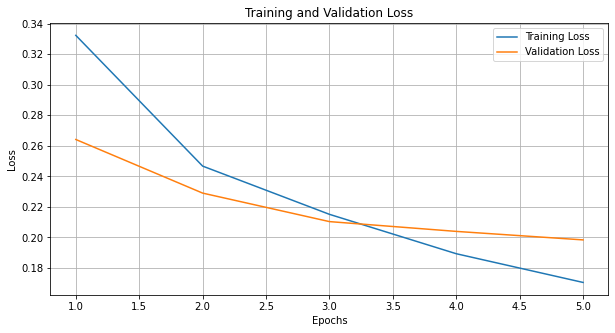

In [11]:

# Initialize lists to store loss values
train_losses = []
val_losses = []

epochs = 5  # Number of epochs
for epoch in range(epochs):
    # Set model to training mode
    model.train()
    total_train_loss = 0

    # Training step
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training")
    for batch in train_progress:
        input_ids, attention_masks, labels = [x.to(device) for x in batch]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss
    print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss}")

    # Validation step
    model.eval()
    total_val_loss = 0

    val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation")
    with torch.no_grad():
        for batch in val_progress:
            input_ids, attention_masks, labels = [x.to(device) for x in batch]

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss

            total_val_loss += loss.item()
            val_progress.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Store validation loss
    print(f"Epoch {epoch+1} - Average Validation Loss: {avg_val_loss}")

# Plot loss curves after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [12]:
# Function to predict on test data
def predict_on_test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            logits = outputs.logits  # Raw scores
            preds = torch.argmax(logits, dim=-1)  # Predicted labels

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels


In [13]:
# Function to decode predictions into human-readable format
def decode_predictions(input_ids, predictions, true_labels, tokenizer, id_to_label):
    decoded_results = []
    for ids, preds, labels in zip(input_ids, predictions, true_labels):
        # Convert token IDs to actual tokens
        tokens = tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True)
        
        # Decode predicted labels and true labels
        pred_labels = [id_to_label.get(p, "UNK") for p in preds[:len(tokens)]]
        true_labels_decoded = [id_to_label.get(t, "UNK") for t in labels[:len(tokens)]]

        decoded_results.append((tokens, pred_labels, true_labels_decoded))
    return decoded_results


In [14]:
# Function to calculate accuracy
def calculate_accuracy(predictions, true_labels, id_to_label):
    total, correct = 0, 0

    for preds, labels in zip(predictions, true_labels):
        preds = preds.flatten()
        labels = labels.flatten()

        for pred, label in zip(preds, labels):
            if id_to_label[label] != "PAD":  # Ignore PAD tokens
                total += 1
                if pred == label:
                    correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy


In [16]:
# Predict on test data
test_loader = DataLoader(TensorDataset(input_ids_test, attention_masks_test, labels_test), batch_size=16)
predictions, true_labels = predict_on_test(model, test_loader)

# Decode predictions
id_to_label = {v: k for k, v in label_to_id.items()}  # Reverse mapping
decoded_results = decode_predictions(
    input_ids_test.tolist(),
    predictions,
    true_labels,
    tokenizer,
    id_to_label
)

# Calculate accuracy
accuracy = calculate_accuracy(predictions, true_labels, id_to_label)
print(f"Test Set Accuracy: {accuracy:.2%}")

# Calculate metrics
valid_preds, valid_labels = calculate_metrics(predictions, true_labels, id_to_label)

# Plot confusion matrix
plot_confusion_matrix(valid_preds, valid_labels, id_to_label)


Test Set Accuracy: 55.01%
Classification Report:
               precision    recall  f1-score   support

         PAD       0.00      0.00      0.00         0
         代名詞       0.59      0.46      0.52        95
          副詞       0.60      0.36      0.45       166
         助動詞       0.45      0.47      0.46      1095
          助詞       0.54      0.59      0.56      3556
          動詞       0.48      0.48      0.48      1593
          名詞       0.66      0.63      0.65      4216
         形容詞       0.45      0.37      0.41       195
         形状詞       0.38      0.26      0.31       148
         感動詞       0.00      0.00      0.00         2
         接尾辞       0.54      0.30      0.38       397
         接続詞       0.97      0.89      0.93        35
         接頭辞       0.45      0.28      0.34       123
        補助記号       0.54      0.51      0.53      1225
          記号       0.44      0.55      0.49       143
         連体詞       0.78      0.58      0.66        85

    accuracy                  

D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334:

ValueError: too many values to unpack (expected 2)

D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334:

Classification Report:
               precision    recall  f1-score   support

         PAD       0.00      0.00      0.00         0
         代名詞       0.59      0.46      0.52        95
          副詞       0.60      0.36      0.45       166
         助動詞       0.45      0.47      0.46      1095
          助詞       0.54      0.59      0.56      3556
          動詞       0.48      0.48      0.48      1593
          名詞       0.66      0.63      0.65      4216
         形容詞       0.45      0.37      0.41       195
         形状詞       0.38      0.26      0.31       148
         感動詞       0.00      0.00      0.00         2
         接尾辞       0.54      0.30      0.38       397
         接続詞       0.97      0.89      0.93        35
         接頭辞       0.45      0.28      0.34       123
        補助記号       0.54      0.51      0.53      1225
          記号       0.44      0.55      0.49       143
         連体詞       0.78      0.58      0.66        85

    accuracy                           0.55     13074
  

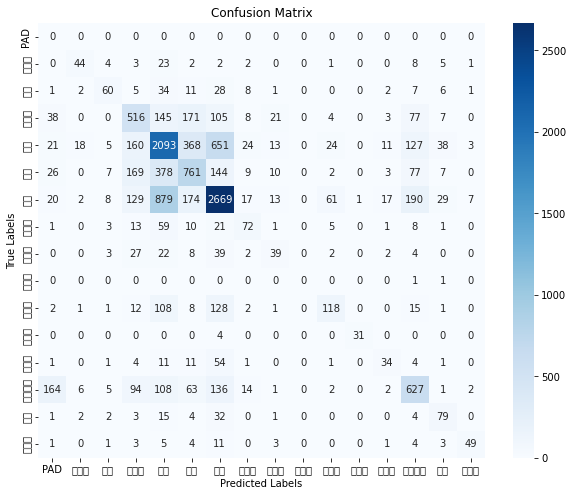

In [17]:


# Function to calculate metrics and display classification report
def calculate_metrics(predictions, true_labels, id_to_label):
    # Flatten predictions and true labels
    preds_flat = [p for preds in predictions for p in preds]
    labels_flat = [l for labels in true_labels for l in labels]

    # Filter out PAD tokens
    valid_preds = [p for p, l in zip(preds_flat, labels_flat) if id_to_label[l] != "PAD"]
    valid_labels = [l for l in labels_flat if id_to_label[l] != "PAD"]

    # Dynamically determine the labels present in the dataset
    unique_labels = sorted(set(valid_labels + valid_preds))
    target_names = [id_to_label[label] for label in unique_labels]

    # Generate classification report
    report = classification_report(valid_labels, valid_preds, labels=unique_labels, target_names=target_names)
    print("Classification Report:\n", report)

    return valid_preds, valid_labels, unique_labels

# Function to plot confusion matrix
def plot_confusion_matrix(valid_preds, valid_labels, unique_labels, id_to_label):
    # Generate confusion matrix
    cm = confusion_matrix(valid_labels, valid_preds, labels=unique_labels)
    target_names = [id_to_label[label] for label in unique_labels]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Main workflow
# Calculate metrics
valid_preds, valid_labels, unique_labels = calculate_metrics(predictions, true_labels, id_to_label)

# Plot confusion matrix
plot_confusion_matrix(valid_preds, valid_labels, unique_labels, id_to_label)


In [ ]:
# Verify the alignment between input tokens and labels
for input_id, label in zip(input_ids_train[:3], labels_train[:3]):
    print("Tokens:", tokenizer.convert_ids_to_tokens(input_id.tolist()))
    print("Labels:", [id_to_label[l] for l in label.tolist()])
